In [ ]:
import pandas as pd
from pandas import np
import json
import requests
from calendar import monthrange
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## **data preprocessing**

In [ ]:
#managing flight data
df = [[] for i in range(24)] #creating a list of lists for 24 months(2 years)
for i in range(1,25):
  if i < 13:
    folderloc = "On_Time_On_Time_Performance_2016_" + str(i)
    fileloc = "On_Time_On_Time_Performance_2016_" + str(i) + ".csv"
    path = "/content/gdrive/My Drive/2016" + "/" + folderloc + "/" + fileloc
    df[i-1].append(pd.read_csv(path)) #appending first 12 months of flight data(2016)
  else:
    i = i - 12
    folderloc = "On_Time_On_Time_Performance_2017_" + str(i)
    fileloc = "On_Time_On_Time_Performance_2017_" + str(i) + ".csv"
    path = "/content/gdrive/My Drive/2017" + "/" + folderloc + "/" + fileloc
    df[i+11].append(pd.read_csv(path)) #appending next 12 months of flight data(2017)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (77,84) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (48,77,84) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (48,77,84,85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local

In [ ]:
#selecting feature columns and updating dataframes
col = ["Year", "Quarter", "Month", "DayofMonth", "FlightDate", "DepTime", "DepDel15", "CRSDepTime", "DepDelayMinutes", 
       "OriginAirportID", "DestAirportID", "ArrTime", "CRSArrTime", "ArrDel15", "ArrDelayMinutes", "Dest","Origin"] #feature cols
upd_df = [[] for i in range(24)]
for i in range(0,13):
  upd_df[i] = df[i][0][col]
  upd_df[i+11] = df[i+11][0][col]

In [ ]:
upd_df[0]

,Year,Quarter,Month,DayofMonth,FlightDate,DepTime,DepDel15,CRSDepTime,DepDelayMinutes,OriginAirportID,DestAirportID,ArrTime,CRSArrTime,ArrDel15,ArrDelayMinutes,Dest,Origin
0,2016,1,1,6,2016-01-06,1057.0,0.0,1100,0.0,11298,11433,1432.0,1438,0.0,0.0,DTW,DFW
1,2016,1,1,7,2016-01-07,1056.0,0.0,1100,0.0,11298,11433,1426.0,1438,0.0,0.0,DTW,DFW
2,2016,1,1,8,2016-01-08,1055.0,0.0,1100,0.0,11298,11433,1445.0,1438,0.0,7.0,DTW,DFW
3,2016,1,1,9,2016-01-09,1102.0,0.0,1100,2.0,11298,11433,1433.0,1438,0.0,0.0,DTW,DFW
4,2016,1,1,10,2016-01-10,1240.0,1.0,1100,100.0,11298,11433,1631.0,1438,1.0,113.0,DTW,DFW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445822,2016,1,1,3,2016-01-03,1240.0,0.0,1245,0.0,11292,14869,1404.0,1409,0.0,0.0,SLC,DEN
445823,2016,1,1,3,2016-01-03,1728.0,1.0,1649,39.0,11292,11278,2241.0,2159,1.0,42.0,DCA,DEN
445824,2016,1,1,3,2016-01-03,1038.0,1.0,1020,18.0,11292,11775,1301.0,1250,0.0,11.0,FSD,DEN
445825,2016,1,1,3,2016-01-03,1358.0,1.0,1335,23.0,11775,11292,1429.0,1426,0.0,3.0,DEN,FSD


In [ ]:
#concatenating all flight data into one dataframe
flight_df = pd.concat(upd_df[i] for i in range(0,24))

In [ ]:
#selecting only featured airports
flight_df1 = pd.DataFrame()
airports = ['ATL','CLT','DEN','DFW','EWR','IAH','JFK','LAS','LAX','MCO','MIA','ORD','PHX','SEA','SFO']
for i in airports:
  flight_df1 = flight_df1.append(flight_df[flight_df.Dest == i]) 

In [ ]:
flight_df2 = pd.DataFrame()
airports = ['ATL','CLT','DEN','DFW','EWR','IAH','JFK','LAS','LAX','MCO','MIA','ORD','PHX','SEA','SFO']
for i in airports:
  flight_df2 = flight_df2.append(flight_df1[flight_df1.Origin == i]) 

In [ ]:
flight_df2 = flight_df2.dropna()

In [ ]:
flight_df2 = flight_df2.reset_index()

In [ ]:
flight_df2 = flight_df2.drop(['index'], axis=1)
flight_df2

,Year,Quarter,Month,DayofMonth,FlightDate,DepTime,DepDel15,CRSDepTime,DepDelayMinutes,OriginAirportID,DestAirportID,ArrTime,CRSArrTime,ArrDel15,ArrDelayMinutes,Dest,Origin
0,2016,1,1,1,2016-01-01,1351.0,0.0,1354,0.0,10397,11057,1503.0,1505,0.0,0.0,CLT,ATL
1,2016,1,1,1,2016-01-01,1536.0,0.0,1535,1.0,10397,11057,1637.0,1648,0.0,0.0,CLT,ATL
2,2016,1,1,1,2016-01-01,1828.0,1.0,1740,48.0,10397,11057,1928.0,1852,1.0,36.0,CLT,ATL
3,2016,1,1,1,2016-01-01,1034.0,0.0,1040,0.0,10397,11057,1143.0,1157,0.0,0.0,CLT,ATL
4,2016,1,1,1,2016-01-01,852.0,0.0,850,2.0,10397,11057,957.0,1009,0.0,0.0,CLT,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851431,2017,4,12,17,2017-12-17,1924.0,0.0,1930,0.0,14771,14747,2130.0,2143,0.0,0.0,SEA,SFO
1851432,2017,4,12,17,2017-12-17,1608.0,0.0,1613,0.0,14771,14747,1818.0,1824,0.0,0.0,SEA,SFO
1851433,2017,4,12,17,2017-12-17,2002.0,0.0,2005,0.0,14771,14747,2226.0,2216,0.0,10.0,SEA,SFO
1851434,2017,4,12,17,2017-12-17,1729.0,0.0,1715,14.0,14771,14747,1930.0,1927,0.0,3.0,SEA,SFO


In [ ]:
for i in range(len(flight_df2.ArrTime)):
  if flight_df2.ArrTime[i] < 100:
    rem = flight_df2.ArrTime[i] % 100
    qu = flight_df2.ArrTime[i] // 100
    if rem < 29:
      flight_df2.ArrTime[i] = 0.0
    else:
      flight_df2.ArrTime[i] = qu * 100 + 100
  else:
    rem = flight_df2.ArrTime[i] % 100
    qu = flight_df2.ArrTime[i] // 100
    if rem < 29:
      flight_df2.ArrTime[i] = qu * 100
    else:
      flight_df2.ArrTime[i] = qu * 100 + 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_la

In [ ]:
for i in range(len(flight_df2.DepTime)):
  if flight_df2.DepTime[i] < 100:
    rem = flight_df2.DepTime[i] % 100
    qu = flight_df2.DepTime[i] // 100
    if rem < 29:
      flight_df2.DepTime[i] = 0.0
    else:
      flight_df2.DepTime[i] = qu * 100 + 100
  else:
    rem = flight_df2.DepTime[i] % 100
    qu = flight_df2.DepTime[i] // 100
    if rem < 29:
      flight_df2.DepTime[i] = qu * 100
    else:
      flight_df2.DepTime[i] = qu * 100 + 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_la

In [ ]:
for i in range(len(flight_df2.DepTime)):
  if flight_df2.DepTime[i] == 2400:
    flight_df2.DepTime[i] = 0.0
for i in range(len(flight_df2.ArrTime)):
  if flight_df2.ArrTime[i] == 2400:
    flight_df2.ArrTime[i] = 0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
flight_df2

,Year,Quarter,Month,DayofMonth,FlightDate,DepTime,DepDel15,CRSDepTime,DepDelayMinutes,OriginAirportID,DestAirportID,ArrTime,CRSArrTime,ArrDel15,ArrDelayMinutes,Dest,Origin
0,2016,1,1,1,2016-01-01,1400.0,0.0,1354,0.0,10397,11057,1500.0,1505,0.0,0.0,CLT,ATL
1,2016,1,1,1,2016-01-01,1600.0,0.0,1535,1.0,10397,11057,1700.0,1648,0.0,0.0,CLT,ATL
2,2016,1,1,1,2016-01-01,1800.0,1.0,1740,48.0,10397,11057,1900.0,1852,1.0,36.0,CLT,ATL
3,2016,1,1,1,2016-01-01,1100.0,0.0,1040,0.0,10397,11057,1200.0,1157,0.0,0.0,CLT,ATL
4,2016,1,1,1,2016-01-01,900.0,0.0,850,2.0,10397,11057,1000.0,1009,0.0,0.0,CLT,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851431,2017,4,12,17,2017-12-17,1900.0,0.0,1930,0.0,14771,14747,2200.0,2143,0.0,0.0,SEA,SFO
1851432,2017,4,12,17,2017-12-17,1600.0,0.0,1613,0.0,14771,14747,1800.0,1824,0.0,0.0,SEA,SFO
1851433,2017,4,12,17,2017-12-17,2000.0,0.0,2005,0.0,14771,14747,2200.0,2216,0.0,10.0,SEA,SFO
1851434,2017,4,12,17,2017-12-17,1800.0,0.0,1715,14.0,14771,14747,2000.0,1927,0.0,3.0,SEA,SFO


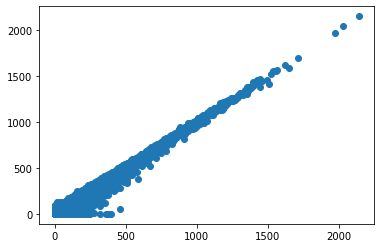

In [ ]:
plt.scatter(flight_df2['ArrDelayMinutes'], flight_df2['DepDelayMinutes'])

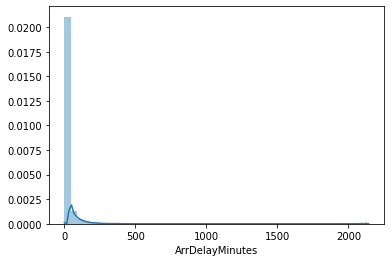

In [ ]:
sns.distplot(flight_df2['ArrDelayMinutes'])

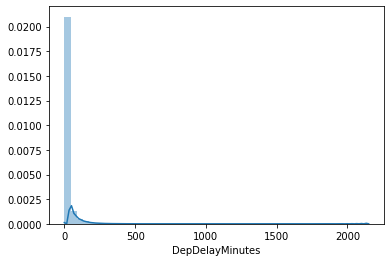

In [ ]:
sns.distplot(flight_df2['DepDelayMinutes'])

**weather data handling**

In [ ]:
#weather data handling
airports = ['ATL','CLT','DEN','DFW','EWR','IAH','JFK','LAS','LAX','MCO','MIA','ORD','PHX','SEA','SFO'] #list of airports
data = [[] for i in range(25)] #data contains list of lists
for i in range(1,25,1):
  for j in range(0,15,1):
    if i < 13:
      path = '/content/gdrive/My Drive/weather/' + airports[j] + '/2016-' + str(i) + ".json"
      with open(path) as f:
        data[i-1].append(json.load(f)) #appending 12 months of data(2016)
    else:
      p = i -12
      path = '/content/gdrive/My Drive/weather/' + airports[j] + '/2017-' + str(p) + ".json"
      with open(path) as f:
        data[p+11].append(json.load(f)) #appending 12 months of data(2017)

In [ ]:
#adding date variable inside hourly weather data for 2016
for i in range(1,13,1):
  j = (monthrange(2016, i)[1]) #finding number of days in month
  for day in range(0,j,1):
    for hour in range(0,24,1):
      for k in range(0,15):
        data[i-1][k]['data']['weather'][day]['hourly'][hour].update({'date':data[i-1][k]['data']['weather'][day]['date']})

In [ ]:
#adding date variable inside hourly weather data for 2017
for i in range(1,13,1):
  j = (monthrange(2017, i)[1])
  for day in range(0,j,1):
    for hour in range(0,24,1):
      for k in range(0,15):
        data[i+11][k]['data']['weather'][day]['hourly'][hour].update({'date':data[i+11][k]['data']['weather'][day]['date']})

In [ ]:
#adding airport variable inside hourly weather data for 2016
airports = ['ATL','CLT','DEN','DFW','EWR','IAH','JFK','LAS','LAX','MCO','MIA','ORD','PHX','SEA','SFO']
for i in range(1,13,1):
  j = (monthrange(2016, i)[1])
  for day in range(0,j,1):
    for hour in range(0,24,1):
      for k in range(0,15):
        data[i-1][k]['data']['weather'][day]['hourly'][hour].update({'airport':airports[k]})

In [ ]:
#adding airport variable inside hourly weather data for 2017
airports = ['ATL','CLT','DEN','DFW','EWR','IAH','JFK','LAS','LAX','MCO','MIA','ORD','PHX','SEA','SFO']
for i in range(1,13,1):
  j = (monthrange(2017, i)[1])
  for day in range(0,j,1):
    for hour in range(0,24,1):
      for k in range(0,15):
        data[i+11][k]['data']['weather'][day]['hourly'][hour].update({'airport':airports[k]})

In [ ]:
#putting all weather data into dataframes
wdf = [[] for i in range(25)]
for i in range(1,25,1):
  for k in range(0,15,1):
    if i < 13: 
      j = 0
      wdf[i-1].append(pd.DataFrame(data[i-1][k]['data']['weather'][j]['hourly'])) 
      j = monthrange(2016,i)[1]
      for day in range(1,j,1):
        wdf[i-1].append(pd.DataFrame(data[i-1][k]['data']['weather'][day]['hourly'])) #wdf having 2016 data for 15 airports
    else:
      j = 0
      wdf[i-1].append(pd.DataFrame(data[i-1][k]['data']['weather'][j]['hourly']))
      j = monthrange(2017,i-12)[1]
      for day in range(1,j,1):
        wdf[i-1].append(pd.DataFrame(data[i-1][k]['data']['weather'][day]['hourly'])) #wdf having 2017 data for 15 airports

In [ ]:
len(wdf[0]) #month one data for all 15 airports

In [ ]:
len(wdf[1])

In [ ]:
len(wdf[3])

In [ ]:
#appending all months of weather data for all airports
upd_wdf = []
for i in range(1,13):
  #k = monthrange(2016,i)[1]
  for j in range(len(wdf[i-1])):
    upd_wdf.append(wdf[i-1][j])
for i in range(1,13):
  #k = monthrange(2017,i)[1]
  for j in range(len(wdf[i+11])):
    upd_wdf.append(wdf[i+11][j])

In [ ]:
(wdf[0][464])

In [ ]:
weather_df = pd.concat(upd_wdf[i] for i in range(10965)) #concatenating two years of weather data for all airports (731 * 15)

In [ ]:
#selecting feature columns
columns = ['windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM', 'visibility',
           'pressure', 'cloudcover', 'DewPointF', 'WindGustKmph', 'tempF',
           'WindChillF', 'humidity', 'time', 'date','airport']
weather_df = weather_df[columns]
weather_df['time'] = weather_df['time'].astype(float)

In [ ]:
weather_df # 731 days(2 years) * 24 hours * 15

,windspeedKmph,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,humidity,time,date,airport
0,11,318,176,0.1,10,1023,100,47,17,49,46,91,0.0,2016-01-01,ATL
1,13,317,176,0.0,10,1023,100,44,22,46,42,92,100.0,2016-01-01,ATL
2,14,315,122,0.0,10,1023,100,41,26,43,38,92,200.0,2016-01-01,ATL
3,16,314,122,0.0,10,1023,100,38,30,40,33,93,300.0,2016-01-01,ATL
4,17,314,122,0.0,10,1023,100,38,30,40,33,93,400.0,2016-01-01,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,2,279,116,0.0,10,1019,51,52,5,55,55,92,1900.0,2017-12-31,SFO
20,2,255,248,0.0,10,1019,44,53,5,55,55,92,2000.0,2017-12-31,SFO
21,1,230,248,0.0,10,1020,38,53,5,55,55,93,2100.0,2017-12-31,SFO
22,2,212,248,0.0,10,1020,58,52,4,53,53,95,2200.0,2017-12-31,SFO


In [ ]:
weather_df = weather_df.reset_index()

In [ ]:
weather_df = weather_df.dropna()
weather_df

,windspeedKmph,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,humidity,time,date,airport
0,11,318,176,0.1,10,1023,100,47,17,49,46,91,0.0,2016-01-01,ATL
1,13,317,176,0.0,10,1023,100,44,22,46,42,92,100.0,2016-01-01,ATL
2,14,315,122,0.0,10,1023,100,41,26,43,38,92,200.0,2016-01-01,ATL
3,16,314,122,0.0,10,1023,100,38,30,40,33,93,300.0,2016-01-01,ATL
4,17,314,122,0.0,10,1023,100,38,30,40,33,93,400.0,2016-01-01,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263155,2,279,116,0.0,10,1019,51,52,5,55,55,92,1900.0,2017-12-31,SFO
263156,2,255,248,0.0,10,1019,44,53,5,55,55,92,2000.0,2017-12-31,SFO
263157,1,230,248,0.0,10,1020,38,53,5,55,55,93,2100.0,2017-12-31,SFO
263158,2,212,248,0.0,10,1020,58,52,4,53,53,95,2200.0,2017-12-31,SFO


In [ ]:
weather_df = weather_df.drop(['index'], axis=1)

In [ ]:
weather_df.airport.unique()

array(['ATL', 'CLT', 'DEN', 'DFW', 'EWR', 'IAH', 'JFK', 'LAS', 'LAX',
       'MCO', 'MIA', 'ORD', 'PHX', 'SEA', 'SFO'], dtype=object)

# Module 1:


## **Merging**

In [ ]:
df_merge1 =  pd.merge(flight_df2,  weather_df, left_on=['FlightDate', 'DepTime', 'Origin'], right_on=['date', 'time', 'airport'], how='left')
df_merge1

,Year,Quarter,Month,DayofMonth,FlightDate,DepTime,DepDel15,CRSDepTime,DepDelayMinutes,OriginAirportID,DestAirportID,ArrTime,CRSArrTime,ArrDel15,ArrDelayMinutes,Dest,Origin,windspeedKmph,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,humidity,time,date,airport
0,2016,1,1,1,2016-01-01,1400.0,0.0,1354,0.0,10397,11057,1500.0,1505,0.0,0.0,CLT,ATL,17,317,122,0.0,10,1025,100,38,21,48,39,76,1400.0,2016-01-01,ATL
1,2016,1,1,1,2016-01-01,1600.0,0.0,1535,1.0,10397,11057,1700.0,1648,0.0,0.0,CLT,ATL,17,318,122,0.0,10,1024,100,37,24,48,39,74,1600.0,2016-01-01,ATL
2,2016,1,1,1,2016-01-01,1800.0,1.0,1740,48.0,10397,11057,1900.0,1852,1.0,36.0,CLT,ATL,17,319,122,0.0,10,1024,100,36,26,45,38,73,1800.0,2016-01-01,ATL
3,2016,1,1,1,2016-01-01,1100.0,0.0,1040,0.0,10397,11057,1200.0,1157,0.0,0.0,CLT,ATL,17,317,122,0.0,10,1025,100,38,20,45,37,84,1100.0,2016-01-01,ATL
4,2016,1,1,1,2016-01-01,900.0,0.0,850,2.0,10397,11057,1000.0,1009,0.0,0.0,CLT,ATL,17,319,122,0.0,10,1025,100,39,20,42,35,92,900.0,2016-01-01,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851431,2017,4,12,17,2017-12-17,1900.0,0.0,1930,0.0,14771,14747,2200.0,2143,0.0,0.0,SEA,SFO,6,299,116,0.0,10,1018,1,44,8,64,64,48,1900.0,2017-12-17,SFO
1851432,2017,4,12,17,2017-12-17,1600.0,0.0,1613,0.0,14771,14747,1800.0,1824,0.0,0.0,SEA,SFO,7,201,113,0.0,10,1017,0,35,10,61,61,38,1600.0,2017-12-17,SFO
1851433,2017,4,12,17,2017-12-17,2000.0,0.0,2005,0.0,14771,14747,2200.0,2216,0.0,10.0,SEA,SFO,6,262,116,0.0,10,1018,1,47,8,64,64,54,2000.0,2017-12-17,SFO
1851434,2017,4,12,17,2017-12-17,1800.0,0.0,1715,14.0,14771,14747,2000.0,1927,0.0,3.0,SEA,SFO,6,337,116,0.0,10,1017,1,42,7,65,65,43,1800.0,2017-12-17,SFO


In [ ]:
df_merge1.airport.unique()

array(['ATL', 'CLT', 'DEN', 'DFW', 'EWR', 'IAH', 'JFK', 'LAS', 'LAX',
       'MCO', 'MIA', 'ORD', 'PHX', 'SEA', 'SFO'], dtype=object)

In [ ]:
df_merge1 = df_merge1.reset_index(drop=True)

In [ ]:
df_merge =  pd.merge(df_merge1,  weather_df, left_on=['FlightDate', 'ArrTime', 'Dest'], right_on=['date', 'time', 'airport'], how='left')
df_merge

,Year,Quarter,Month,DayofMonth,FlightDate,DepTime,DepDel15,CRSDepTime,DepDelayMinutes,OriginAirportID,DestAirportID,ArrTime,CRSArrTime,ArrDel15,ArrDelayMinutes,Dest,Origin,windspeedKmph_x,winddirDegree_x,weatherCode_x,precipMM_x,visibility_x,pressure_x,cloudcover_x,DewPointF_x,WindGustKmph_x,tempF_x,WindChillF_x,humidity_x,time_x,date_x,airport_x,windspeedKmph_y,winddirDegree_y,weatherCode_y,precipMM_y,visibility_y,pressure_y,cloudcover_y,DewPointF_y,WindGustKmph_y,tempF_y,WindChillF_y,humidity_y,time_y,date_y,airport_y
0,2016,1,1,1,2016-01-01,1400.0,0.0,1354,0.0,10397,11057,1500.0,1505,0.0,0.0,CLT,ATL,17,317,122,0.0,10,1025,100,38,21,48,39,76,1400.0,2016-01-01,ATL,8,298,122,0.0,10,1022,100,42,10,51,49,73,1500.0,2016-01-01,CLT
1,2016,1,1,1,2016-01-01,1600.0,0.0,1535,1.0,10397,11057,1700.0,1648,0.0,0.0,CLT,ATL,17,318,122,0.0,10,1024,100,37,24,48,39,74,1600.0,2016-01-01,ATL,8,294,122,0.0,10,1022,100,42,11,50,48,75,1700.0,2016-01-01,CLT
2,2016,1,1,1,2016-01-01,1800.0,1.0,1740,48.0,10397,11057,1900.0,1852,1.0,36.0,CLT,ATL,17,319,122,0.0,10,1024,100,36,26,45,38,73,1800.0,2016-01-01,ATL,8,294,122,0.0,10,1022,100,41,12,49,47,74,1900.0,2016-01-01,CLT
3,2016,1,1,1,2016-01-01,1100.0,0.0,1040,0.0,10397,11057,1200.0,1157,0.0,0.0,CLT,ATL,17,317,122,0.0,10,1025,100,38,20,45,37,84,1100.0,2016-01-01,ATL,6,108,119,0.0,10,1023,86,41,8,48,46,78,1200.0,2016-01-01,CLT
4,2016,1,1,1,2016-01-01,900.0,0.0,850,2.0,10397,11057,1000.0,1009,0.0,0.0,CLT,ATL,17,319,122,0.0,10,1025,100,39,20,42,35,92,900.0,2016-01-01,ATL,7,48,143,0.0,6,1023,90,42,9,47,44,86,1000.0,2016-01-01,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851431,2017,4,12,17,2017-12-17,1900.0,0.0,1930,0.0,14771,14747,2200.0,2143,0.0,0.0,SEA,SFO,6,299,116,0.0,10,1018,1,44,8,64,64,48,1900.0,2017-12-17,SFO,15,205,122,0.0,9,1015,100,42,39,45,38,88,2200.0,2017-12-17,SEA
1851432,2017,4,12,17,2017-12-17,1600.0,0.0,1613,0.0,14771,14747,1800.0,1824,0.0,0.0,SEA,SFO,7,201,113,0.0,10,1017,0,35,10,61,61,38,1600.0,2017-12-17,SFO,12,204,122,0.0,10,1016,100,42,40,44,37,90,1800.0,2017-12-17,SEA
1851433,2017,4,12,17,2017-12-17,2000.0,0.0,2005,0.0,14771,14747,2200.0,2216,0.0,10.0,SEA,SFO,6,262,116,0.0,10,1018,1,47,8,64,64,54,2000.0,2017-12-17,SFO,15,205,122,0.0,9,1015,100,42,39,45,38,88,2200.0,2017-12-17,SEA
1851434,2017,4,12,17,2017-12-17,1800.0,0.0,1715,14.0,14771,14747,2000.0,1927,0.0,3.0,SEA,SFO,6,337,116,0.0,10,1017,1,42,7,65,65,43,1800.0,2017-12-17,SFO,14,204,122,0.0,9,1016,100,42,39,45,38,88,2000.0,2017-12-17,SEA


In [ ]:
df_merge.dropna()

,Year,Quarter,Month,DayofMonth,FlightDate,DepTime,DepDel15,CRSDepTime,DepDelayMinutes,OriginAirportID,DestAirportID,ArrTime,CRSArrTime,ArrDel15,ArrDelayMinutes,Dest,Origin,windspeedKmph_x,winddirDegree_x,weatherCode_x,precipMM_x,visibility_x,pressure_x,cloudcover_x,DewPointF_x,WindGustKmph_x,tempF_x,WindChillF_x,humidity_x,time_x,date_x,airport_x,windspeedKmph_y,winddirDegree_y,weatherCode_y,precipMM_y,visibility_y,pressure_y,cloudcover_y,DewPointF_y,WindGustKmph_y,tempF_y,WindChillF_y,humidity_y,time_y,date_y,airport_y
0,2016,1,1,1,2016-01-01,1400.0,0.0,1354,0.0,10397,11057,1500.0,1505,0.0,0.0,CLT,ATL,17,317,122,0.0,10,1025,100,38,21,48,39,76,1400.0,2016-01-01,ATL,8,298,122,0.0,10,1022,100,42,10,51,49,73,1500.0,2016-01-01,CLT
1,2016,1,1,1,2016-01-01,1600.0,0.0,1535,1.0,10397,11057,1700.0,1648,0.0,0.0,CLT,ATL,17,318,122,0.0,10,1024,100,37,24,48,39,74,1600.0,2016-01-01,ATL,8,294,122,0.0,10,1022,100,42,11,50,48,75,1700.0,2016-01-01,CLT
2,2016,1,1,1,2016-01-01,1800.0,1.0,1740,48.0,10397,11057,1900.0,1852,1.0,36.0,CLT,ATL,17,319,122,0.0,10,1024,100,36,26,45,38,73,1800.0,2016-01-01,ATL,8,294,122,0.0,10,1022,100,41,12,49,47,74,1900.0,2016-01-01,CLT
3,2016,1,1,1,2016-01-01,1100.0,0.0,1040,0.0,10397,11057,1200.0,1157,0.0,0.0,CLT,ATL,17,317,122,0.0,10,1025,100,38,20,45,37,84,1100.0,2016-01-01,ATL,6,108,119,0.0,10,1023,86,41,8,48,46,78,1200.0,2016-01-01,CLT
4,2016,1,1,1,2016-01-01,900.0,0.0,850,2.0,10397,11057,1000.0,1009,0.0,0.0,CLT,ATL,17,319,122,0.0,10,1025,100,39,20,42,35,92,900.0,2016-01-01,ATL,7,48,143,0.0,6,1023,90,42,9,47,44,86,1000.0,2016-01-01,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851431,2017,4,12,17,2017-12-17,1900.0,0.0,1930,0.0,14771,14747,2200.0,2143,0.0,0.0,SEA,SFO,6,299,116,0.0,10,1018,1,44,8,64,64,48,1900.0,2017-12-17,SFO,15,205,122,0.0,9,1015,100,42,39,45,38,88,2200.0,2017-12-17,SEA
1851432,2017,4,12,17,2017-12-17,1600.0,0.0,1613,0.0,14771,14747,1800.0,1824,0.0,0.0,SEA,SFO,7,201,113,0.0,10,1017,0,35,10,61,61,38,1600.0,2017-12-17,SFO,12,204,122,0.0,10,1016,100,42,40,44,37,90,1800.0,2017-12-17,SEA
1851433,2017,4,12,17,2017-12-17,2000.0,0.0,2005,0.0,14771,14747,2200.0,2216,0.0,10.0,SEA,SFO,6,262,116,0.0,10,1018,1,47,8,64,64,54,2000.0,2017-12-17,SFO,15,205,122,0.0,9,1015,100,42,39,45,38,88,2200.0,2017-12-17,SEA
1851434,2017,4,12,17,2017-12-17,1800.0,0.0,1715,14.0,14771,14747,2000.0,1927,0.0,3.0,SEA,SFO,6,337,116,0.0,10,1017,1,42,7,65,65,43,1800.0,2017-12-17,SFO,14,204,122,0.0,9,1016,100,42,39,45,38,88,2000.0,2017-12-17,SEA


In [ ]:
#dropping null values
#df_merge = 
df_merge.isnull().sum()

Year               0
Quarter            0
Month              0
DayofMonth         0
FlightDate         0
DepTime            0
DepDel15           0
CRSDepTime         0
DepDelayMinutes    0
OriginAirportID    0
DestAirportID      0
ArrTime            0
CRSArrTime         0
ArrDel15           0
ArrDelayMinutes    0
Dest               0
Origin             0
windspeedKmph_x    0
winddirDegree_x    0
weatherCode_x      0
precipMM_x         0
visibility_x       0
pressure_x         0
cloudcover_x       0
DewPointF_x        0
WindGustKmph_x     0
tempF_x            0
WindChillF_x       0
humidity_x         0
time_x             0
date_x             0
airport_x          0
windspeedKmph_y    0
winddirDegree_y    0
weatherCode_y      0
precipMM_y         0
visibility_y       0
pressure_y         0
cloudcover_y       0
DewPointF_y        0
WindGustKmph_y     0
tempF_y            0
WindChillF_y       0
humidity_y         0
time_y             0
date_y             0
airport_y          0
dtype: int64

In [ ]:
df_merge

,Year,Quarter,Month,DayofMonth,FlightDate,DepTime,DepDel15,CRSDepTime,DepDelayMinutes,OriginAirportID,DestAirportID,ArrTime,CRSArrTime,ArrDel15,ArrDelayMinutes,Dest,Origin,windspeedKmph_x,winddirDegree_x,weatherCode_x,precipMM_x,visibility_x,pressure_x,cloudcover_x,DewPointF_x,WindGustKmph_x,tempF_x,WindChillF_x,humidity_x,time_x,date_x,airport_x,windspeedKmph_y,winddirDegree_y,weatherCode_y,precipMM_y,visibility_y,pressure_y,cloudcover_y,DewPointF_y,WindGustKmph_y,tempF_y,WindChillF_y,humidity_y,time_y,date_y,airport_y
0,2016,1,1,1,2016-01-01,1400.0,0.0,1354,0.0,10397,11057,1500.0,1505,0.0,0.0,CLT,ATL,17,317,122,0.0,10,1025,100,38,21,48,39,76,1400.0,2016-01-01,ATL,8,298,122,0.0,10,1022,100,42,10,51,49,73,1500.0,2016-01-01,CLT
1,2016,1,1,1,2016-01-01,1600.0,0.0,1535,1.0,10397,11057,1700.0,1648,0.0,0.0,CLT,ATL,17,318,122,0.0,10,1024,100,37,24,48,39,74,1600.0,2016-01-01,ATL,8,294,122,0.0,10,1022,100,42,11,50,48,75,1700.0,2016-01-01,CLT
2,2016,1,1,1,2016-01-01,1800.0,1.0,1740,48.0,10397,11057,1900.0,1852,1.0,36.0,CLT,ATL,17,319,122,0.0,10,1024,100,36,26,45,38,73,1800.0,2016-01-01,ATL,8,294,122,0.0,10,1022,100,41,12,49,47,74,1900.0,2016-01-01,CLT
3,2016,1,1,1,2016-01-01,1100.0,0.0,1040,0.0,10397,11057,1200.0,1157,0.0,0.0,CLT,ATL,17,317,122,0.0,10,1025,100,38,20,45,37,84,1100.0,2016-01-01,ATL,6,108,119,0.0,10,1023,86,41,8,48,46,78,1200.0,2016-01-01,CLT
4,2016,1,1,1,2016-01-01,900.0,0.0,850,2.0,10397,11057,1000.0,1009,0.0,0.0,CLT,ATL,17,319,122,0.0,10,1025,100,39,20,42,35,92,900.0,2016-01-01,ATL,7,48,143,0.0,6,1023,90,42,9,47,44,86,1000.0,2016-01-01,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851431,2017,4,12,17,2017-12-17,1900.0,0.0,1930,0.0,14771,14747,2200.0,2143,0.0,0.0,SEA,SFO,6,299,116,0.0,10,1018,1,44,8,64,64,48,1900.0,2017-12-17,SFO,15,205,122,0.0,9,1015,100,42,39,45,38,88,2200.0,2017-12-17,SEA
1851432,2017,4,12,17,2017-12-17,1600.0,0.0,1613,0.0,14771,14747,1800.0,1824,0.0,0.0,SEA,SFO,7,201,113,0.0,10,1017,0,35,10,61,61,38,1600.0,2017-12-17,SFO,12,204,122,0.0,10,1016,100,42,40,44,37,90,1800.0,2017-12-17,SEA
1851433,2017,4,12,17,2017-12-17,2000.0,0.0,2005,0.0,14771,14747,2200.0,2216,0.0,10.0,SEA,SFO,6,262,116,0.0,10,1018,1,47,8,64,64,54,2000.0,2017-12-17,SFO,15,205,122,0.0,9,1015,100,42,39,45,38,88,2200.0,2017-12-17,SEA
1851434,2017,4,12,17,2017-12-17,1800.0,0.0,1715,14.0,14771,14747,2000.0,1927,0.0,3.0,SEA,SFO,6,337,116,0.0,10,1017,1,42,7,65,65,43,1800.0,2017-12-17,SFO,14,204,122,0.0,9,1016,100,42,39,45,38,88,2000.0,2017-12-17,SEA


In [ ]:
df_merge.describe()

,Year,Quarter,Month,DayofMonth,DepTime,DepDel15,CRSDepTime,DepDelayMinutes,OriginAirportID,DestAirportID,ArrTime,CRSArrTime,ArrDel15,ArrDelayMinutes,time_x,time_y
count,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06,1.851436e+06
mean,2.016494e+03,2.515180e+00,6.544073e+00,1.576746e+01,1.326890e+03,2.009678e-01,1.327428e+03,1.403783e+01,1.273775e+04,1.273823e+04,1.432453e+03,1.496641e+03,2.095984e-01,1.426119e+01,1.326890e+03,1.432453e+03
std,4.999633e-01,1.104736e+00,3.396908e+00,8.790680e+00,5.346987e+02,4.007241e-01,5.115290e+02,4.152727e+01,1.354932e+03,1.354563e+03,5.956147e+02,5.431142e+02,4.070221e-01,4.143587e+01,5.346987e+02,5.956147e+02
min,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.039700e+04,1.039700e+04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.016000e+03,2.000000e+00,4.000000e+00,8.000000e+00,9.000000e+02,0.000000e+00,9.050000e+02,0.000000e+00,1.129800e+04,1.129800e+04,1.000000e+03,1.110000e+03,0.000000e+00,0.000000e+00,9.000000e+02,1.000000e+03
50%,2.016000e+03,3.000000e+00,7.000000e+00,1.600000e+01,1.300000e+03,0.000000e+00,1.316000e+03,0.000000e+00,1.289200e+04,1.289200e+04,1.500000e+03,1.534000e+03,0.000000e+00,0.000000e+00,1.300000e+03,1.500000e+03
75%,2.017000e+03,3.000000e+00,9.000000e+00,2.300000e+01,1.800000e+03,0.000000e+00,1.737000e+03,9.000000e+00,1.393000e+04,1.393000e+04,1.900000e+03,1.938000e+03,0.000000e+00,1.000000e+01,1.800000e+03,1.900000e+03
max,2.017000e+03,4.000000e+00,1.200000e+01,3.100000e+01,2.300000e+03,1.000000e+00,2.359000e+03,2.149000e+03,1.477100e+04,1.477100e+04,2.300000e+03,2.400000e+03,1.000000e+00,2.142000e+03,2.300000e+03,2.300000e+03


In [ ]:
df_merge.reset_index()

In [ ]:
df_merge.to_csv("/content/sample_data/mergeddata.csv")